In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Load the dataset
df = pd.read_csv('station_data_dataverse.csv')

# Display first few rows
print(df.head())

# Show DataFrame structure
print(df.info())

# Show basic statistics
print(df.describe(include='all'))

# Check for missing values
print(df.isnull().sum())

# Check data types of each column
print(df.dtypes)


   sessionId  kwhTotal  dollars              created                ended  \
0    1366563      7.78     0.00  0014-11-18 15:40:26  0014-11-18 17:11:04   
1    3075723      9.74     0.00  0014-11-19 17:40:26  0014-11-19 19:51:04   
2    4228788      6.76     0.58  0014-11-21 12:05:46  0014-11-21 16:46:04   
3    3173284      6.17     0.00  0014-12-03 19:16:12  0014-12-03 21:02:18   
4    3266500      0.93     0.00  0014-12-11 20:56:11  0014-12-11 21:14:06   

   startTime  endTime  chargeTimeHrs weekday platform  ...  managerVehicle  \
0         15       17       1.510556     Tue  android  ...               0   
1         17       19       2.177222     Wed  android  ...               0   
2         12       16       4.671667     Fri  android  ...               0   
3         19       21       1.768333     Wed  android  ...               0   
4         20       21       0.298611     Thu  android  ...               0   

   facilityType  Mon  Tues  Wed  Thurs  Fri  Sat  Sun  reportedZip  

In [3]:
import pandas as pd
df['created'] = df['created'].astype(str)
# Replace year 0014 with 2014
df['created'] = df['created'].str.replace('0014', '2014')
# Replace year 0015 with 2015
df['created'] = df['created'].str.replace('0015', '2015')
# Then convert to datetime
df['created'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Confirm fix
print(df['created'].head())


# Remove rows with null timestamps or kWh values
df = df.dropna(subset=['created', 'kwhTotal'])

# Group by date and sum kwhTotal for each day
daily_df = df.groupby(df['created'].dt.date)['kwhTotal'].sum().reset_index()

# Rename columns to match Prophet format
daily_df.columns = ['ds', 'y']

daily_df['ds'] = pd.to_datetime(daily_df['ds'])

# Check the result
print(daily_df.head())


0   2014-11-18 15:40:26
1   2014-11-19 17:40:26
2   2014-11-21 12:05:46
3   2014-12-03 19:16:12
4   2014-12-11 20:56:11
Name: created, dtype: datetime64[ns]
          ds      y
0 2014-11-18  13.39
1 2014-11-19  18.77
2 2014-11-20   6.95
3 2014-11-21  14.14
4 2014-11-24   6.69


In [4]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Determine split index (80% for training)
split_index = int(len(daily_df) * 0.8)

# Create train and test sets
train_df = daily_df.iloc[:split_index]
test_df = daily_df.iloc[split_index:]

# Confirm the split
print(f"Training set: {train_df.shape[0]} rows")
print(f"Test set: {test_df.shape[0]} rows")
print("Train range:", train_df['ds'].min(), "to", train_df['ds'].max())
print("Test range:", test_df['ds'].min(), "to", test_df['ds'].max())


Training set: 190 rows
Test set: 48 rows
Train range: 2014-11-18 00:00:00 to 2015-08-14 00:00:00
Test range: 2015-08-15 00:00:00 to 2015-10-04 00:00:00


In [7]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Initialize the Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.3,   # optional: controls trend flexibility
    seasonality_prior_scale=5.0    # optional: controls seasonality detail
)

# Fit the model on training data
model.fit(train_df)


07:58:55 - cmdstanpy - INFO - Chain [1] start processing
07:58:56 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
# Create a future DataFrame for prediction (full range: training + test period)
future = model.make_future_dataframe(periods=len(test_df), freq='D')

# Generate forecast
forecast = model.predict(future)

# Keep only the forecasted values for the test date range
forecast_test = forecast[forecast['ds'].isin(test_df['ds'])]

# Preview forecast for test period
print(forecast_test[['ds', 'yhat']].head())


            ds        yhat
190 2015-08-15  112.062714
192 2015-08-17  225.999911
193 2015-08-18  237.625955
194 2015-08-19  256.547607
195 2015-08-20  277.026532


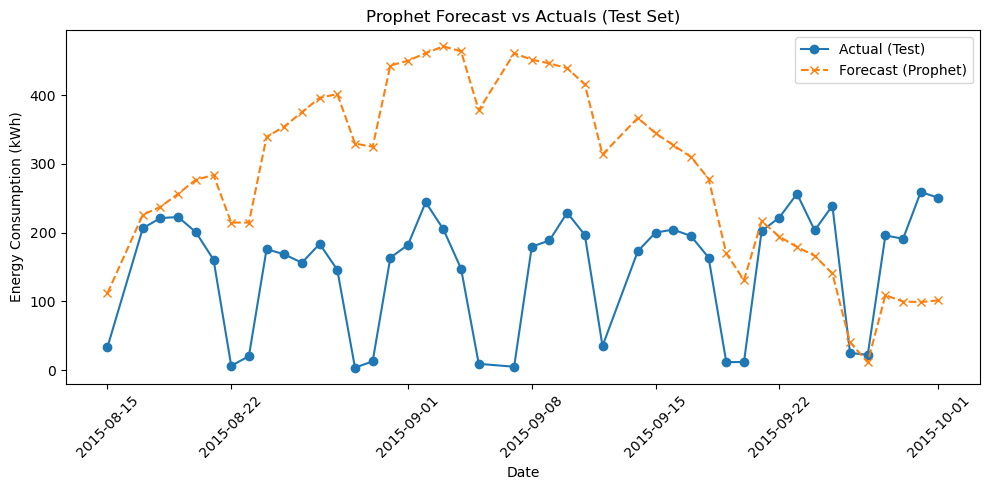

In [10]:
import matplotlib.pyplot as plt

# Merge test actuals with forecasted values
merged = test_df.merge(forecast_test[['ds', 'yhat']], on='ds')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(merged['ds'], merged['y'], label='Actual (Test)', marker='o')
plt.plot(merged['ds'], merged['yhat'], label='Forecast (Prophet)', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Prophet Forecast vs Actuals (Test Set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Compare predicted vs actual values
y_true = merged['y']
y_pred = merged['yhat']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE (Mean Absolute Error): {mae:.2f} kWh")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} kWh")


MAE (Mean Absolute Error): 168.15 kWh
RMSE (Root Mean Squared Error): 198.60 kWh


In [18]:
pip install pmdarima


   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   --------------------------------------- 625.1/625.1 kB 11.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------  2.6/2.7 MB 12.5 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 11.0 MB/s eta 0:00:00


In [12]:
from pmdarima import auto_arima

# Fit ARIMA model on training data only
arima_model = auto_arima(train_df['y'],
                         d=1,             # confirmed from ADF test
                         start_p=0, start_q=0,
                         max_p=5, max_q=5,
                         seasonal=False,
                         trace=True,
                         suppress_warnings=True,
                         stepwise=True)

print(arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2003.778, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1998.049, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2001.859, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1985.839, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1981.682, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1962.540, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1894.988, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1884.542, Time=0.38 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1904.218, Time=0.28 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1881.851, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1901.741, Time=0.42 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1871.313, Time=0.55 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1871.496, Time=0.49 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : 

In [14]:
# Forecast the next 48 days (same as test set)
n_periods = len(test_df)
arima_forecast = arima_model.predict(n_periods=n_periods)

# Instead of using test_df['ds'], rebuild a correct date range
start_date = train_df['ds'].max() + pd.Timedelta(days=1)
forecast_dates = pd.date_range(start=start_date, periods=n_periods, freq='D')

# Recreate prediction DataFrame
arima_pred_df = pd.DataFrame({
    'ds': forecast_dates,
    'yhat': arima_forecast
})

# Now merge again with test set
arima_merged = test_df.merge(arima_pred_df, on='ds')

# Check merged output
print(arima_merged.head())


          ds       y        yhat
0 2015-08-15   33.62  101.930584
1 2015-08-17  206.49  194.252620
2 2015-08-18  221.27  131.953321
3 2015-08-19  222.75  123.292632
4 2015-08-20  200.72  155.247478


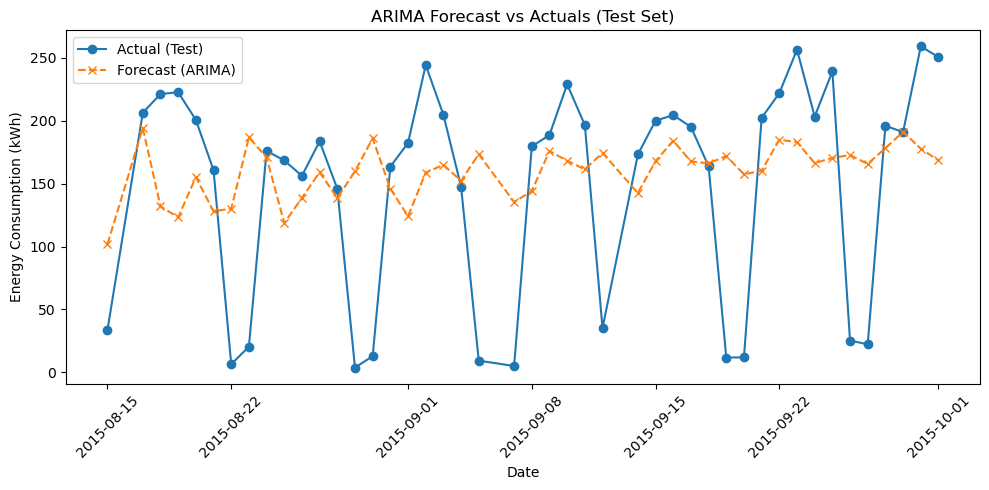

ARIMA MAE: 66.77 kWh
ARIMA RMSE: 85.59 kWh


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Plot predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(arima_merged['ds'], arima_merged['y'], label='Actual (Test)', marker='o')
plt.plot(arima_merged['ds'], arima_merged['yhat'], label='Forecast (ARIMA)', linestyle='--', marker='x')
plt.title('ARIMA Forecast vs Actuals (Test Set)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate metrics
mae = mean_absolute_error(arima_merged['y'], arima_merged['yhat'])
rmse = np.sqrt(mean_squared_error(arima_merged['y'], arima_merged['yhat']))

print(f"ARIMA MAE: {mae:.2f} kWh")
print(f"ARIMA RMSE: {rmse:.2f} kWh")


Prophet is widely used for time-series forecasting due to its ease of use and built-in handling of seasonality, it did not perform well on our EV charging dataset in this case. After training the model on historical daily kWh consumption and evaluating it on a test set (using an 80/20 split), we observed the following:

MAE: 168.15 kWh

RMSE: 198.60 kWh

These values indicate a high average error and some large deviations between actual and predicted values. Upon visual inspection, the Prophet model failed to capture the short-term fluctuations — especially weekday peaks and weekend dips — and instead produced a smoother, flatter forecast.

In contrast, ARIMA(5,1,5), which was tuned using auto_arima, delivered:

MAE: 66.78 kWh

RMSE: 85.59 kWh

This significant reduction in error demonstrates that ARIMA better fits the characteristics of our data, likely because it handles autoregressive components more effectively than Prophet’s default trend-seasonality assumptions